In [1]:
#https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/
#https://github.com/ismailuddin/gradcam-tensorflow-2/blob/master/notebooks/GradCam.ipynb
#https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
import os
import cv2
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data.dataset import Dataset

from torchvision.models import vgg19, resnet50
import torchvision.datasets as datasets

from pycocotools.coco import COCO

from sklearn.model_selection import train_test_split

import gc
import shutil
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image


transformations = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Use the ImageNet data statistics for normalization

/home/sriram/.local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


Prepare the dataset class to pre-process the images and return the images and labels to feed into the model training

In [3]:
class DatasetProcessing(Dataset):
    def __init__(self, data_path, img_path, ann_path, transform=None, dataType = 'train'):
        
        self.ann_path = os.path.join(data_path, "annotations", ann_path)
        self.img_path = os.path.join(data_path, img_path)       

        coco=COCO(self.ann_path)
        catIDs = coco.getCatIds()
        cats = coco.loadCats(catIDs)

        annIDs = coco.getAnnIds(catIds=catIDs, iscrowd = False)
        anns = coco.loadAnns(ids=annIDs)        

        imgIDs = []
        labelIDs = []
        for i in range(0,len(anns)):
            imgIDs.append(anns[i]['image_id'])
            labelIDs.append(anns[i]['category_id'])

        imgIDs = np.array(imgIDs)
        labelIDs = np.array(labelIDs)
        uniqueImgIDs = np.unique(imgIDs)

        uniqueTargetLabels = []
        orderedLabels = np.arange(0,len(catIDs)).astype(np.uint8)
        for i in tqdm(range(0,len(uniqueImgIDs))):
            targetLabels = labelIDs[imgIDs == uniqueImgIDs[i]]
            uniqueLabels = np.unique(targetLabels)
            actualLabels = np.zeros(len(uniqueLabels))
            for j in range(0,len(uniqueLabels)):
                actualLabels[j] = orderedLabels[catIDs == uniqueLabels[j]]
            uniqueTargetLabels.append(actualLabels)

        uniqueImgIDs = uniqueImgIDs.tolist()
        imgs = coco.loadImgs(ids=uniqueImgIDs)

        imgFilenames = []
        labels = np.zeros((len(imgs),len(catIDs)))
        for i in range(0,len(imgs)):
            imgFilenames.append(imgs[i]['file_name'])    
            uniqueTargetLabels[i] = uniqueTargetLabels[i].astype(np.uint8)        
            labels[i,uniqueTargetLabels[i]] = 1

        if dataType != 'test':
            train_x, val_x, train_y, val_y = train_test_split(imgFilenames, labels, test_size=0.33, random_state=2021)
            if dataType == 'train':
                self.img_filename = train_x
                self.label = train_y
            elif dataType == 'val':
                self.img_filename = val_x
                self.label = val_y
        else:
            self.img_filename = imgFilenames
            self.label = labels

        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_path, self.img_filename[index]))
        img = img.convert('RGB')
        img = np.array(img)

        def resize_with_padding(im, desired_size = 224):
            """ Resize Image into a square based on desired_size with padding
            """
            old_size = im.shape[:2] # old_size is in (height, width) format

            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])

            # new_size should be in (width, height) format

            im = cv2.resize(im, (new_size[1], new_size[0]))

            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
            return new_im

        img = resize_with_padding(img)
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        label = torch.from_numpy(self.label[index])
                
        return img, label
    
    def __len__(self):
        return len(self.img_filename)

In [4]:
DATA_PATH = "/media/HD1/sriram/data/coco"

TRAIN_IMG_PATH = "train2017"
TRAIN_ANN_PATH = "instances_train2017.json"

TEST_IMG_PATH = "val2017"
TEST_ANN_PATH = "instances_val2017.json"

MODEL_PATH_FULL = "/media/HD1/sriram/models/vgg_train_coco_80classes_v3.pt"

In [5]:
# Create the training set and validation set
train_set = DatasetProcessing(DATA_PATH, TRAIN_IMG_PATH, TRAIN_ANN_PATH, transform = transformations, dataType = 'train')
val_set = DatasetProcessing(DATA_PATH, TRAIN_IMG_PATH, TRAIN_ANN_PATH, transform = transformations, dataType = 'val')

loading annotations into memory...
Done (t=8.94s)
creating index...
index created!


100%|██████████| 117266/117266 [00:21<00:00, 5483.49it/s]


loading annotations into memory...
Done (t=8.47s)
creating index...
index created!


100%|██████████| 117266/117266 [00:21<00:00, 5401.44it/s]


In [6]:
# Create the data loaders for training set and validation set
batch_size = 64
batch_size_train = 64
batch_size_val = 32
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=False, num_workers=4)

In [7]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
# Modify the VGG19 base model to fit the COCO data via transfer learning.
num_classes = 80
model = vgg19(pretrained = True)
model.classifier[6] = nn.Linear(4096, num_classes)

# Transfer learning of VGG16 for MSCOCO dataset with 80 classes.
# Train only the last FC layer. Freeze the parameters in the other layers.
# for param in model.named_parameters():
#     if 'classifier' not in param[0]:
#         param[1].requires_grad = False

for param in model.named_parameters():
    print(param[0],param[1].requires_grad)

if train_on_gpu:
    model.cuda()

features.0.weight True
features.0.bias True
features.2.weight True
features.2.bias True
features.5.weight True
features.5.bias True
features.7.weight True
features.7.bias True
features.10.weight True
features.10.bias True
features.12.weight True
features.12.bias True
features.14.weight True
features.14.bias True
features.16.weight True
features.16.bias True
features.19.weight True
features.19.bias True
features.21.weight True
features.21.bias True
features.23.weight True
features.23.bias True
features.25.weight True
features.25.bias True
features.28.weight True
features.28.bias True
features.30.weight True
features.30.bias True
features.32.weight True
features.32.bias True
features.34.weight True
features.34.bias True
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


In [8]:
num_classes = 80
LOAD_MODEL_PATH = "/media/HD1/sriram/models/vgg_train_coco_80classes_v2.pt"
model = torch.load(LOAD_MODEL_PATH)
if train_on_gpu:
    model.cuda()

Train the model

In [9]:
# Create the optimizer and loss function
import torch.optim as optim

# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

optimizer = optim.SGD(
    [
    {"params": model.features[0:10].parameters(), "lr": 10e-6},
    {"params": model.features[10:19].parameters(), "lr": 10e-5},
    {"params": model.features[19:28].parameters(), "lr": 10e-4},
    {"params": model.features[28:].parameters(), "lr": 10e-4},
    {"params": model.classifier.parameters(), "lr": 10e-4}
    ],
    lr = 10e-3
)

In [10]:
# number of epochs to train the model
n_epochs = 1000
early_stop = 0
EARLY_STOP_COUNT = 10
valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
val_loss_list = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    running_correct_preds = 0
    running_labels = 0
    model.train()
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
            
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        dummy = torch.zeros((target.shape[0],num_classes)).type(torch.int64)
        predictions = torch.sigmoid(output).detach().cpu()
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        correctPreds = torch.where(((predictions > dummy) & (predictions == target.detach().cpu())),1,0)
        running_correct_preds += torch.sum(correctPreds)        
        running_labels += torch.sum(target)

        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()

    train_accuracy = (running_correct_preds / running_labels) * 100

    # Validate the Model
    model.eval()
    running_correct_preds = 0
    running_labels = 0
    for data, target in val_loader:
        # Move tensor to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        with torch.no_grad():
            output = model(data)
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)

        # Calculate accuracy on val set
        dummy = torch.zeros((target.shape[0],num_classes)).type(torch.int64)
        predictions = torch.sigmoid(output).detach().cpu()
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        correctPreds = torch.where(((predictions > dummy) & (predictions == target.detach().cpu())),1,0)
        running_correct_preds += torch.sum(correctPreds)        
        running_labels += torch.sum(target)

    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(val_loader.dataset)

    # calculate validation accuracy
    val_accuracy = (running_correct_preds/running_labels) * 100

    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.10f} \t Training Accuracy: {:.2f} \tValidation Loss: {:.10f} \tValidation Accuracy {:.2f}'.format(
        epoch, train_loss, train_accuracy, valid_loss, val_accuracy))
    
    # save training/validation statistics
    train_loss_list.append(train_loss)
    val_loss_list.append(valid_loss)    

    # Save model at every 100 epochs
    if np.mod(epoch,100) == 0:
        torch.save(model.save_dict(),MODEL_PATH_FULL)    
        print('Saving model')
        
    # save model if validation loss has decreased
    if valid_loss < valid_loss_min:
        print('Validation loss decreased ({:.10f} --> {:.10f}).'.format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        early_stop = 0
    else:
        early_stop += 1
    if early_stop >= EARLY_STOP_COUNT:
        break

/home/sriram/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 0.0006655308 	 Training Accuracy: 66.98 	Validation Loss: 0.0602281535 	Validation Accuracy 62.33
Validation loss decreased (inf --> 0.0602281535).
Epoch: 2 	Training Loss: 0.0006644167 	 Training Accuracy: 67.12 	Validation Loss: 0.0602696852 	Validation Accuracy 62.52
Epoch: 3 	Training Loss: 0.0006629610 	 Training Accuracy: 67.22 	Validation Loss: 0.0602887132 	Validation Accuracy 62.54
Epoch: 4 	Training Loss: 0.0006621700 	 Training Accuracy: 67.35 	Validation Loss: 0.0603170771 	Validation Accuracy 62.60
Epoch: 5 	Training Loss: 0.0006620807 	 Training Accuracy: 67.37 	Validation Loss: 0.0603169101 	Validation Accuracy 62.58
Epoch: 6 	Training Loss: 0.0006622182 	 Training Accuracy: 67.34 	Validation Loss: 0.0603293075 	Validation Accuracy 62.62
Epoch: 7 	Training Loss: 0.0006614225 	 Training Accuracy: 67.46 	Validation Loss: 0.0603470583 	Validation Accuracy 62.68
Epoch: 8 	Training Loss: 0.0006613257 	 Training Accuracy: 67.57 	Validation Loss: 0.0603

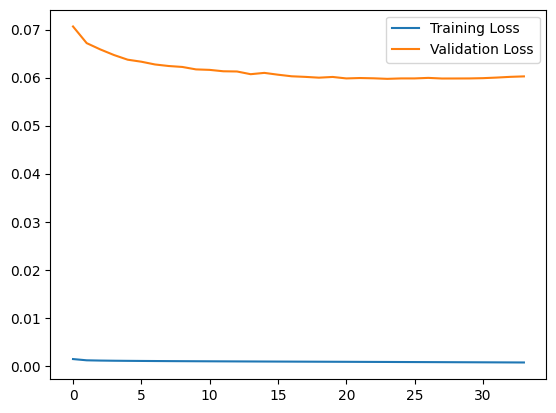

In [16]:
# Plot training loss vs validation loss

plt.figure()
plt.plot(train_loss_list,label="Training Loss")
plt.plot(val_loss_list,label="Validation Loss")
plt.legend()
plt.show()

Save the Trained Model

In [60]:
for param in model.parameters():
    param.requires_grad = True

In [11]:
torch.save(model, MODEL_PATH_FULL)
model = torch.load(MODEL_PATH_FULL)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Evaluate the classification accuracy of the trained model on the Val 2017 dataset

In [12]:
test_set = DatasetProcessing(DATA_PATH, TEST_IMG_PATH, TEST_ANN_PATH, transform = transformations, dataType = 'test')

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


100%|██████████| 4952/4952 [00:00<00:00, 39880.86it/s]


In [15]:
model = torch.load(MODEL_PATH_FULL)
model.eval()

num_classes = 80
running_correct_preds = 0
running_labels = 0
with torch.no_grad():
    for i in tqdm(range(0,len(test_set))):
        images, lbls = test_set[i]

        img = torch.clone(images)
        lbl = torch.clone(lbls)
        img = img.unsqueeze(0)
        lbl = lbl.unsqueeze(0)
        img, lbl = img.cuda(), lbl.cuda()

        outputs = model(img)        

        dummy = torch.zeros((lbl.shape[0],num_classes)).type(torch.int64)
        predictions = torch.sigmoid(outputs).cpu()
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        correctPreds = torch.where(((predictions > dummy) & (predictions == lbl.detach().cpu())),1,0)
        running_correct_preds += torch.sum(correctPreds)        
        running_labels += torch.sum(lbl)

print('Accuracy of the model on val 2017 images: %d %%' % (running_correct_preds / running_labels * 100))

100%|██████████| 4952/4952 [00:32<00:00, 152.27it/s]

Accuracy of the model on val 2017 images: 61 %
